In [104]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import pytorch_lightning as pl

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tqdm

ModuleNotFoundError: No module named 'pytorch_lightning'

In [21]:
target_raw_1 = np.load('/home/sviatoslav/Downloads/vel2_1_0.npy')
target_raw_2 = np.load('/home/sviatoslav/Downloads/vel4_1_0.npy')
target_raw = np.concatenate([target_raw_1, target_raw_2], axis=0).reshape((-1,70,70))
target_scaled = (target_raw - target_raw.min())/(target_raw.max() - target_raw.min())

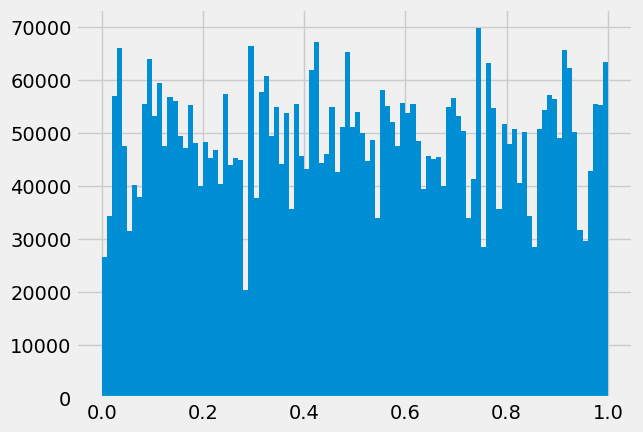

In [85]:
plt.hist(target_scaled.flatten(), bins=100);

In [86]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(70 * 70, 2048),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            #nn.ReLU(),
            #nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            #nn.Linear(64, 128),
            #nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 70 * 70),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [130]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [131]:
model = Autoencoder()
loss_function = nn.MSELoss()
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
print(model.parameters())

<generator object Module.parameters at 0x7e4cd1422b20>


In [ ]:
epochs = 200
outputs = []
losses = []
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm.tqdm(range(epochs)):
    #for entry in target_scaled[0:700]:
    for i in range(0, int(len(target_scaled)*0.7), batch_size):
        entry = target_scaled[i:i+batch_size]
        tensor = torch.Tensor(entry.reshape(-1, 1, 70,70)).to(device)
        reconstructed = model(tensor)
        #print(reconstructed.shape)
        loss = loss_function(reconstructed, tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, entry, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([1, 4900])


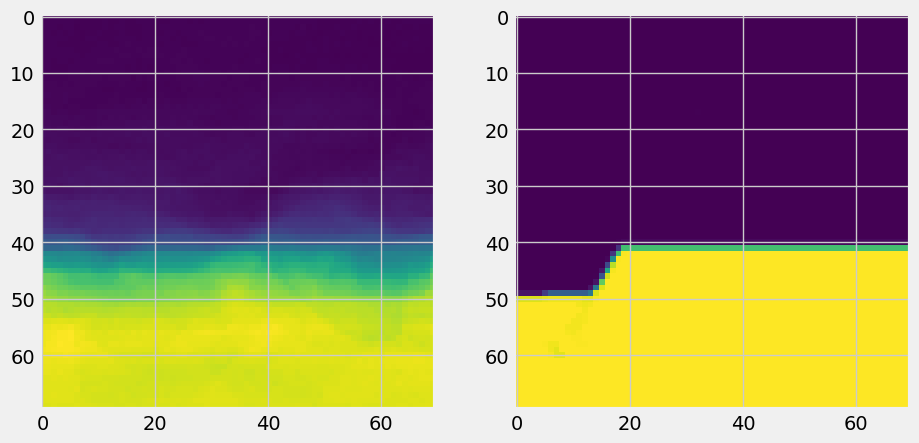

In [95]:
i = 113
tensor = torch.Tensor(target_scaled[i].reshape(1, 70*70)).to(device)
print(tensor.shape)
entry = model(tensor).detach().numpy()

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[1].imshow(target_scaled[i])
axs[0].imshow(entry.reshape(70,70))